# AXA coding challenge - data visualization and analysis
Data:
1. Citibike: https://s3.amazonaws.com/tripdata/index.html
2. NYPD:  https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [131]:
# Import modules
import os # basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter # to set y-values to scientific
import seaborn as sns
import time
import sklearn as sk
from scipy import stats
import dask.dataframe as dd
import pickle

import folium # library for interactive map visualizations
from folium.plugins import HeatMap
import geopandas

import sys
sys.path.append("C:/Users/Hanna/sciebo/Python_scripts")
from statistical_test import * # extensive script for stats I use often, created by one of my colleagues, Kamil Pradel
import pingouin

import warnings

In [132]:
# Functions
def plot_sum_timeline(df, variables, period, xy_labels, plot_title, label_colours_dict, save_name):
    '''
    Function plotting one or more variables (column names) over time, taking the sum per month or year
    
    - variables: col name (str) or list of col names (str)
    - label_colours_dict: dict variable: colour -> label will be first matched to variable (col name), then taken from last part of name, eg if variable
        is 'number_of_cyclist_injured', label will be 'injured'
    - save_name: name of figure. Figure will be saved in fig_dir, as save_fig_as
    '''
    
    if period == 'month':
        period = ['year', 'month']
    
    # Create sum of variables per year and month
    period_sum = (
        df_accidents.groupby(period)[variables]
        .sum()
        .reset_index()
    )

    #print(monthly_sum.head()) # check 
    period_sum['date'] = pd.to_datetime(period_sum[period].assign(day=1))

    # Plot
    fig, axes = plt.subplots(len(variables),1, figsize=(12, 4*len(variables)), sharex=False); axes = axes.flatten();
    plt.suptitle(plot_title)
    for i, var in enumerate(variables):
        label = var.split('_')[-1]
        axes[i].plot(period_sum['date'], period_sum[var], marker='o', color=label_colours_dict[var], label=label)
        axes[i].set_xlabel(xy_labels[0][i])
        axes[i].set_ylabel(xy_labels[1][i])
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid()
        axes[i].legend()
        plt.tight_layout()

    fig.savefig(os.path.join(results_dir, save_name), format=save_fig_as) # save figure

def plot_combined_bike_metrics(df):
    
    df_bike_collisions = df[df['bike_involved'] == 'bike'] # filter rows where a bike is involved
    # new column to identify whether a cyclist was injured or killed
    df_bike_collisions['cyclist_hurt'] = df_bike_collisions['number_of_cyclists_injured'] + df_bike_collisions['number_of_cyclists_killed']
    
    # group by time period (year or month) and calculate the total number of collisions
    total_collisions = (df.groupby(['year', 'month']).size().reset_index(name='total_collisions'))

    # Calculate the total number of cyclists injured or killed for each month
    cyclist_hurt_by_month = (
        df_bike_collisions.groupby(['year', 'month'])['cyclist_hurt']
        .sum()
        .reset_index(name='total_cyclist_hurt')
    )

    merged_data = pd.merge(total_collisions, cyclist_hurt_by_month, on=['year', 'month'], how='left').fillna(0) # merge both dfs on year and month
    merged_data['cyclist_hurt_percentage'] = (merged_data['total_cyclist_hurt'] / merged_data['total_collisions']) * 100 #% cyclists injured or killed out of total collisions
    merged_data['date'] = pd.to_datetime(merged_data[['year', 'month']].assign(day=1))  # convert year and month to a datetime column for plotting

    bike_collision_filter = df[['bike_involved']].eq('bike').any(axis=1) # filter bike collisions
    df['is_bike_collision'] = bike_collision_filter

    # count bike collisions
    df['crash_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    monthly_totals = df.groupby('crash_month').size().reset_index(name='total_collisions')
    bike_collisions = df[df['is_bike_collision']].groupby('crash_month').size().reset_index(name='bike_collisions')

    bike_collision_data = pd.merge(monthly_totals, bike_collisions, on='crash_month', how='left').fillna(0)

    # % of bike collisions
    bike_collision_data['bike_collision_percentage'] = (bike_collision_data['bike_collisions'] / bike_collision_data['total_collisions']) * 100

    fig = plt.figure(figsize=(12, 6))

    # % collisions involving bike
    plt.plot(bike_collision_data['crash_month'], bike_collision_data['bike_collision_percentage'], marker='o', color='blue', 
             label='Percentage of bike collisions (% of total collisions)')
    # % cyclist injuries/fatalities from total collisions
    plt.plot(merged_data['date'], merged_data['cyclist_hurt_percentage'], marker='o', color='orange', 
             label='Cyclist injury/fatality (% of total collisions)')

    plt.title('Bike collisions')
    plt.xlabel('Date (year, month)')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(results_dir, 'bike_collisions.'+save_fig_as), format=save_fig_as) # save figure


def plot_injured_killed(df, category, iax=0):
    sns.barplot(data=df[df['type'] == category], x='group', y='count_sum', ax=axs[iax], 
            palette=colour_palette, alpha=0.7, order=['pedestrians','cyclists'])
    sns.stripplot(data=df[df['type'] == category], x='group', y='count_sum', ax=axs[iax], color='black', 
                  dodge=True, size=4, jitter=True, edgecolor='gray', linewidth=0.5, legend=False, order=['pedestrians','cyclists']);
    axs[iax].set_title(f'Average number of people {category}')
    axs[iax].set_ylabel('Avg. number of people/year (#)')
    # add stats to plot
    sum_ = df.loc[df['type'] == category]
    stats_ = statistical_test( {"cyclists": sum_.loc[sum_['group'] == 'cyclists', 'count_sum'], 
                                "pedestrians":  sum_.loc[sum_['group'] == 'pedestrians', 'count_sum']}, pairing='paired');
    p_color = color_p(stats_["p-value"].item(), sign, not_sign); # get color for p-value text, dependen on whether significant
    print(f'{stats_.test.item()} for {category}: p-value = {stats_["p-value"].item():.6f}')
    #print(stats_injured)
    axs[iax].annotate(f'p-value={stats_["p-value"].item():.4f}', xy=(0.5, 0.9), 
                    xycoords='axes fraction', ha='center', va='bottom', fontsize=10, xytext=(0, 10), textcoords='offset points', color=p_color)


def annotate_pvals(plot, p_values, ax=None):
    if ax is None:
        ax = plot.ax
    for i, p_value in enumerate(p_values):
        color = color_p(p_value);
        ax.annotate(f'p={p_value:.3f}', (i, 0), xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, color=color)
        
def color_p(pval, sign="crimson", not_sign="slategrey"): # determine colour of p value depicted in figure
    if pval < 0.05: 
        p_color = sign; 
    else:
        p_color = not_sign;
    return p_color

In [117]:
# Some settings
current_dir = os.getcwd() # current dir
cleaned_dir = current_dir + '/data/bike-tripdata_cleaned' # directory where cleaned and concatenated bike-trip data is saved
results_dir = current_dir + '/results' # directory where figures will be saved
if not os.path.exists(results_dir): # create if doens´t exist
    os.makedirs(results_dir) 
    
save_fig_as = 'jpg' # save figures as, eg 'pdf', 'jpg', 'svg', 'png'
sign="crimson"; not_sign="slategrey" # colors p_val text

warnings.filterwarnings("ignore")

# Accident data
## Get a sense of the severity of bike accidents in NYC; how often do they occur, what % of collisions involved a cyclist, what % of collisions caused injuries/death?

In [58]:
# Load accident data
df_accidents = pd.read_csv(cleaned_dir + '/collisions_cleaned.csv')
df_accidents.columns

Index(['Unnamed: 0', 'borough', 'zip_code', 'accident_latitude',
       'accident_longitude', 'location', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclists_injured',
       'number_of_cyclists_killed', 'number_of_motorists_injured',
       'number_of_motorists_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'collision_id', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5',
       'crash_datetime', 'year', 'month', 'bike_involved'],
      dtype='object')

In [35]:
df_accidents.dtypes

Unnamed: 0                         int64
borough                           object
zip_code                           Int64
accident_latitude                float64
accident_longitude               float64
location                          object
on_street_name                    object
cross_street_name                 object
off_street_name                   object
number_of_persons_injured          int64
number_of_persons_killed           int64
number_of_pedestrians_injured      int64
number_of_pedestrians_killed       int64
number_of_cyclists_injured         int64
number_of_cyclists_killed          int64
number_of_motorists_injured        int64
number_of_motorists_killed         int64
contributing_factor_vehicle_1     object
contributing_factor_vehicle_2     object
contributing_factor_vehicle_3     object
contributing_factor_vehicle_4     object
contributing_factor_vehicle_5     object
collision_id                     float64
vehicle_type_code_1               object
vehicle_type_cod

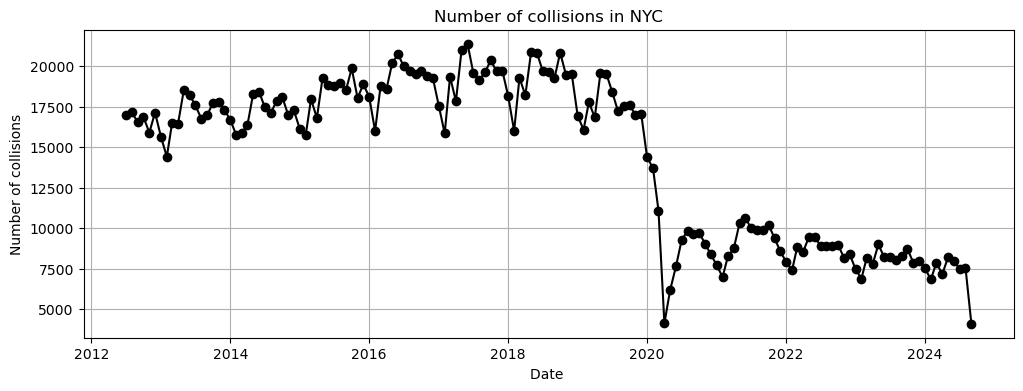

In [59]:
# Create sum of variables per year and month
monthly_count = (
    df_accidents.groupby(['year', 'month'])['number_of_cyclists_injured']
    .count()
    .reset_index()
)

monthly_count['date'] = pd.to_datetime(monthly_count[['year', 'month']].assign(day=1))

# Plot
fig, axes = plt.subplots(1,1, figsize=(12, 4), sharex=True);
axes.plot(monthly_count['date'], monthly_count['number_of_cyclists_injured'], marker='o', color='k', label='Total collisions (#)')
#axes[i].plot(monthly_accidents['date'], monthly_accidents[var], marker='o', color=label_colours_dict[var], label=label)
axes.set_xlabel('Date ')
axes.set_title('Number of collisions in NYC')
axes.set_ylabel('Number of collisions')
#axes.tick_params(axis='x', rotation=45)
axes.grid()

fig.savefig(os.path.join(results_dir,'monthly_collisions_total.jpg'), format='jpg') # save figure

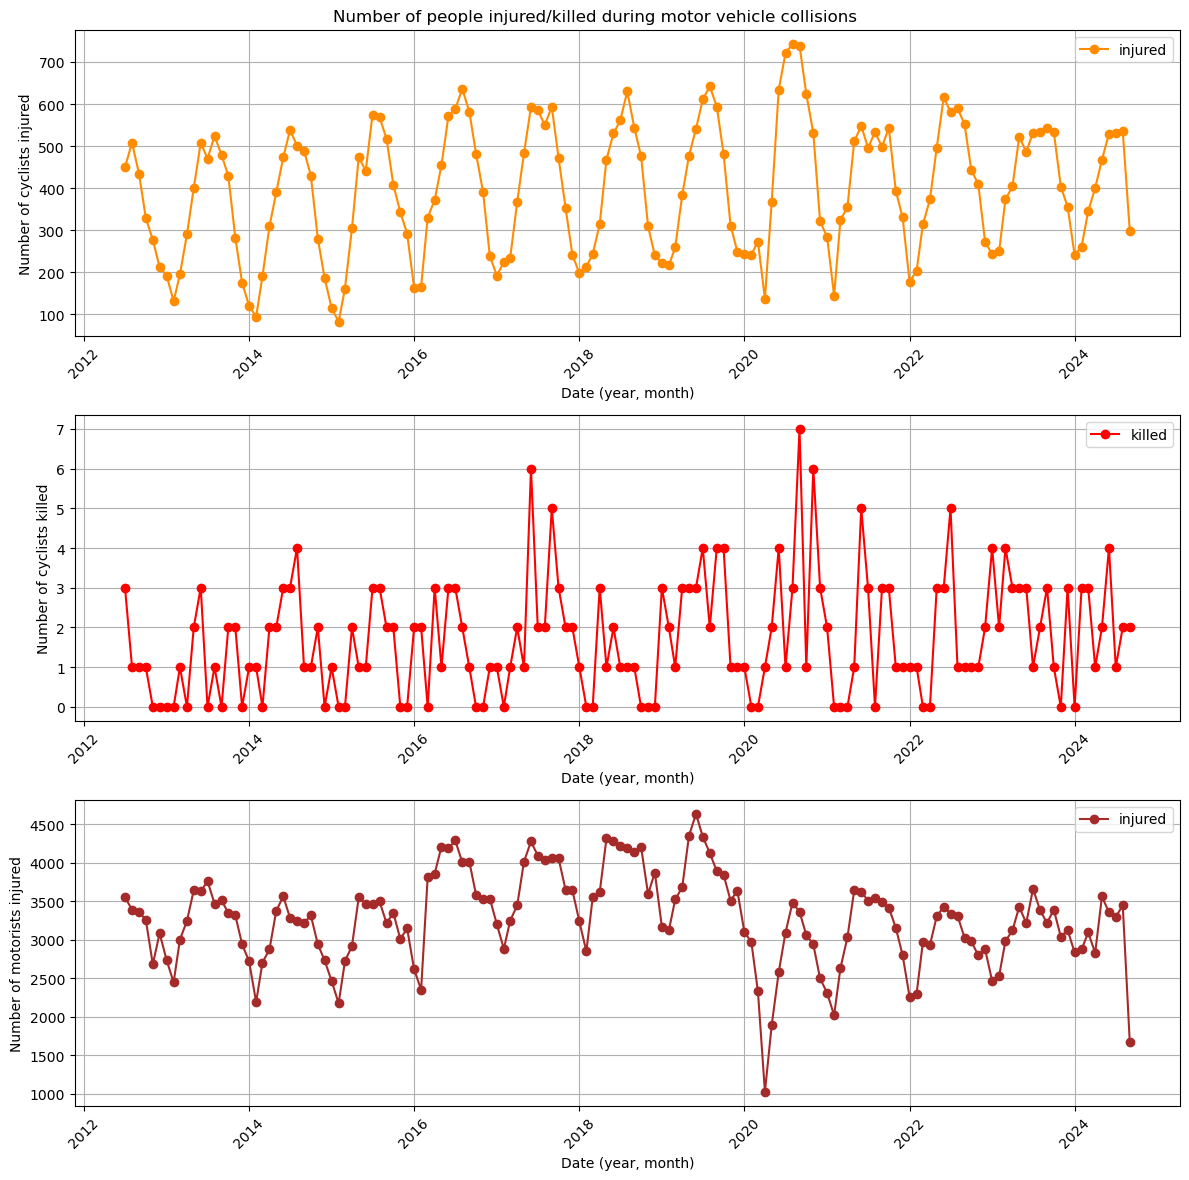

In [36]:
variables = ['number_of_cyclists_injured','number_of_cyclists_killed','number_of_motorists_injured']
period = 'month'
xy_labels = [['Date (year, month)','Date (year, month)','Date (year, month)'],['Number of cyclists injured','Number of cyclists killed','Number of motorists injured']]
plot_title = 'Number of people injured/killed during motor vehicle collisions'
label_colours_dict = {'number_of_cyclists_injured':'darkorange','number_of_cyclists_killed':'red','number_of_motorists_injured':'brown'}
save_name = 'monthly_accidents.jpg'

plot_sum_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)

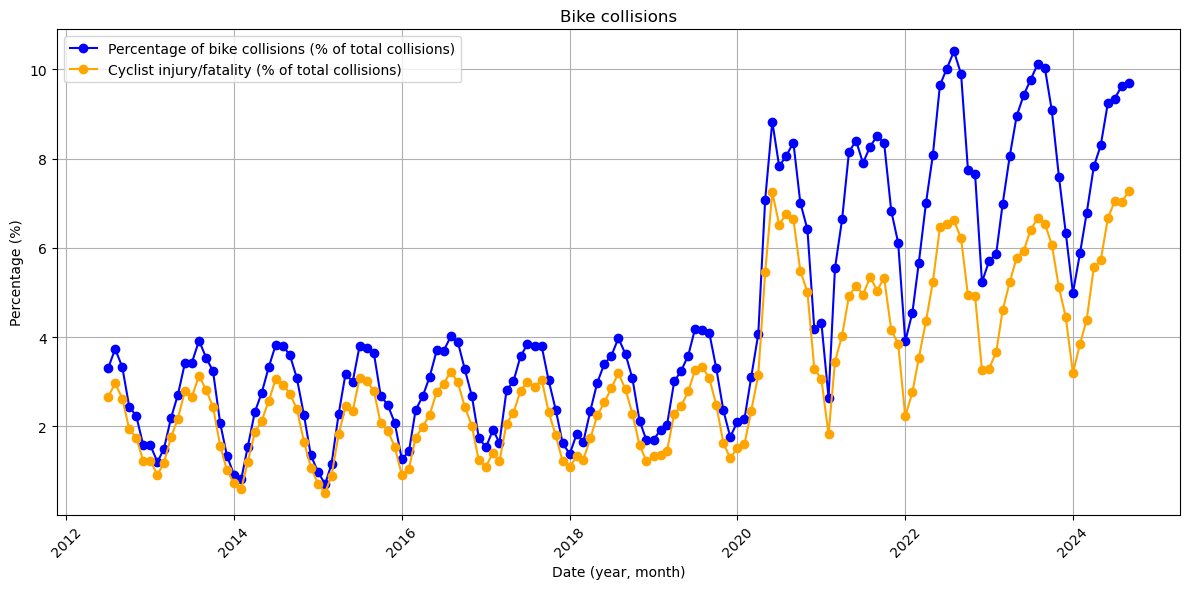

In [60]:
# How many of the collisions involved a bike? And how many involved injured/killed cyclists?
# to avoid error, try: 
pd.options.mode.copy_on_write = True 
plot_combined_bike_metrics(df_accidents)

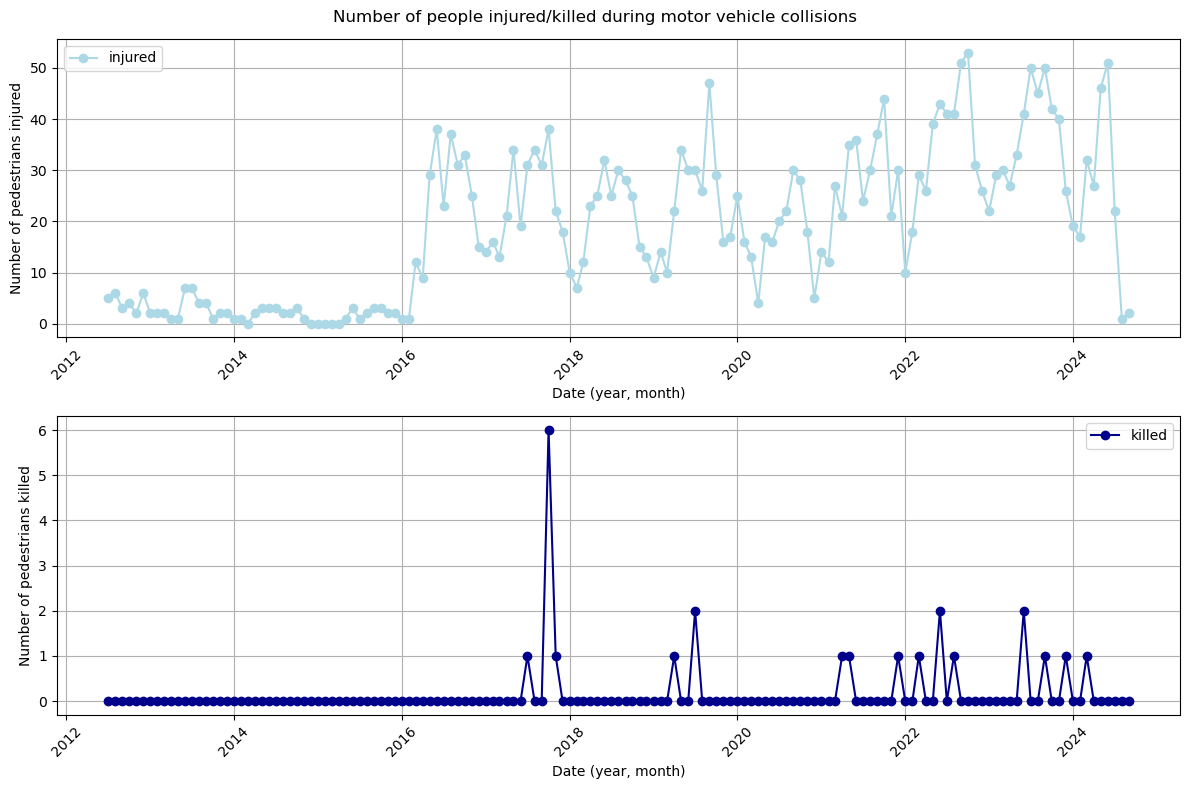

In [108]:
variables = ['number_of_pedestrians_injured','number_of_pedestrians_killed']
period = 'month'
xy_labels = [['Date (year, month)','Date (year, month)'],
             ['Number of pedestrians injured','Number of pedestrians killed']]
plot_title = 'Number of people injured/killed during motor vehicle collisions'
label_colours_dict = {'number_of_cyclists_injured':'darkorange','number_of_cyclists_killed':'red',
                      'number_of_pedestrians_injured':'lightblue','number_of_pedestrians_killed':'darkblue'}
save_name = 'monthly_accidents_pedestrians.jpg'

plot_sum_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)

In [141]:
df_accidents.head()

,Unnamed: 0,borough,zip_code,accident_latitude,accident_longitude,location,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,...,vehicle_type_code_4,vehicle_type_code_5,crash_datetime,year,month,bike_involved,is_bike_collision,crash_month,lat_bin,lon_bin
4,4,brooklyn,11215,40.677406,-73.983048,"(40.6774056, -73.9830482)",4 avenue,union street,unknown,0,...,unknown,unknown,2012-07-01 00:20:00,2012,7,bike,True,2012-07-01,"(40.656, 40.703]","(-74.043, -73.983]"
42,42,manhattan,10065,40.764162,-73.968890,"(40.7641617, -73.9688897)",east 61 street,park avenue,unknown,1,...,unknown,unknown,2012-07-01 02:30:00,2012,7,bike,True,2012-07-01,"(40.75, 40.797]","(-73.983, -73.922]"
98,98,bronx,10468,40.862679,-73.909040,"(40.8626793, -73.9090397)",sedgwick avenue,west fordham road,unknown,1,...,unknown,unknown,2012-07-01 06:50:00,2012,7,bike,True,2012-07-01,"(40.844, 40.89]","(-73.922, -73.862]"
108,108,brooklyn,11218,40.633745,-73.972283,"(40.633745, -73.9722831)",ocean parkway,avenue f,unknown,0,...,unknown,unknown,2012-07-01 07:30:00,2012,7,bike,True,2012-07-01,"(40.609, 40.656]","(-73.983, -73.922]"
202,202,brooklyn,11211,40.711801,-73.942229,"(40.7118008, -73.9422288)",grand street,humboldt street,unknown,1,...,unknown,unknown,2012-07-01 12:15:00,2012,7,bike,True,2012-07-01,"(40.703, 40.75]","(-73.983, -73.922]"


Wilcoxon signed-rank test (paired) for injured: p-value = 0.000244
Wilcoxon signed-rank test (paired) for killed: p-value = 0.000244
t-test (paired) for injured: p-value = 0.000000
t-test (paired) for killed: p-value = 0.002155


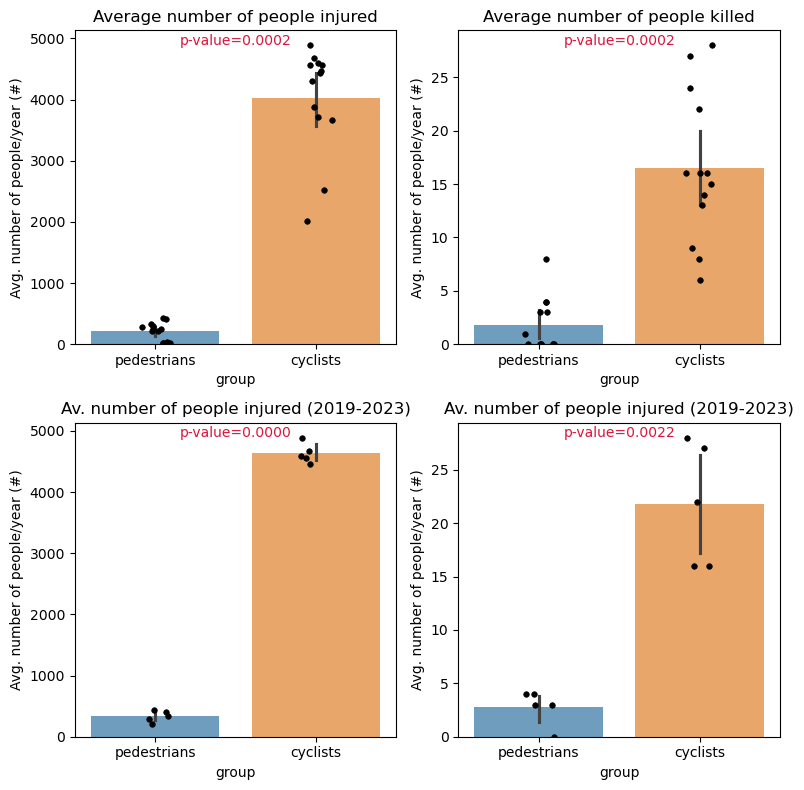

In [209]:
# Are more cyclists injured/killed than pedestrians?
#df_accidents.group_by(['year'])
colour_palette = {'pedestrians': '#1f77b4','cyclists': '#ff7f0e' }
select_years = (2019,2023)

df_yearly = df_accidents.groupby('year').agg({
    'number_of_cyclists_injured': 'sum',
    'number_of_pedestrians_injured': 'sum',
    'number_of_cyclists_killed': 'sum',
    'number_of_pedestrians_killed': 'sum'
}).reset_index()

df_melted = df_yearly.melt(id_vars='year', 
                           value_vars=['number_of_cyclists_injured', 'number_of_pedestrians_injured',
                                       'number_of_cyclists_killed', 'number_of_pedestrians_killed'],
                           var_name='category', value_name='count_sum')

# Create a new column to distinguish injured vs killed
df_melted['type'] = df_melted['category'].apply(lambda x: 'injured' if 'injured' in x else 'killed')
df_melted['group'] = df_melted['category'].apply(lambda x: 'cyclists' if 'cyclists' in x else 'pedestrians')

fig, axs = plt.subplots(2, 2, figsize=(8, 8)); axs = axs.flatten()

plot_injured_killed(df_melted, 'injured', 0)
plot_injured_killed(df_melted, 'killed', 1)

select_years = (2019,2023) # select time period

df_melted_sel = df_melted.loc[df_melted['year'].between(select_years[0],select_years[1])]
plot_injured_killed(df_melted_sel, 'injured', 2)
axs[2].set_title(f'Av. number of people {category} ({select_years[0]}-{select_years[1]})')
plot_injured_killed(df_melted_sel, 'killed', 3)
axs[3].set_title(f'Av. number of people {category} ({select_years[0]}-{select_years[1]})')
plt.tight_layout()

fig.savefig(os.path.join(results_dir,'accidents_injuries-killed_pedestrians-cyclists.jpg'), format='jpg') # save figure

In [189]:
# p-values are the same for injured and killed, yet there are no mistakes. Check the stats values to be sure
print(stats_killed)
print(stats_injured)

   cyclists_mean  pedestrians_mean  cyclists_SD  pedestrians_SD  cyclists_SEM  \
0      16.461538          1.769231     6.732417        2.390811      1.867237   

   pedestrians_SEM  cyclists_median  pedestrians_median  cyclists_Q1  \
0         0.663092             16.0                 0.0         13.0   

   pedestrians_Q1  cyclists_Q3  pedestrians_Q3  cyclists_N  pedestrians_N  \
0             0.0         22.0             3.0          13             13   

                                 test  statistic   p-value  df  
0  Wilcoxon signed-rank test (paired)        0.0  0.000244 NaN  
   cyclists_mean  pedestrians_mean  cyclists_SD  pedestrians_SD  cyclists_SEM  \
0    4021.076923        213.692308   834.464956      140.604948    231.438938   

   pedestrians_SEM  cyclists_median  pedestrians_median  cyclists_Q1  \
0        38.996796           4441.0               245.0       3715.0   

   pedestrians_Q1  cyclists_Q3  pedestrians_Q3  cyclists_N  pedestrians_N  \
0            35.0     

In [149]:
df_melted

,year,category,count_sum,type,group
0,2012,number_of_cyclists_injured,2016,injured,cyclists
1,2013,number_of_cyclists_injured,3715,injured,cyclists
2,2014,number_of_cyclists_injured,3661,injured,cyclists
3,2015,number_of_cyclists_injured,3877,injured,cyclists
4,2016,number_of_cyclists_injured,4299,injured,cyclists
5,2017,number_of_cyclists_injured,4572,injured,cyclists
6,2018,number_of_cyclists_injured,4441,injured,cyclists
7,2019,number_of_cyclists_injured,4459,injured,cyclists
8,2020,number_of_cyclists_injured,4590,injured,cyclists
9,2021,number_of_cyclists_injured,4559,injured,cyclists


We see that more cyclists than pedestrians get injured and killed during a collision with a motor vehicle (yet even more motorists).

Unfortunately, there is no data about age or gender in the accident dataset, so we can not investigate which gender and age group is most likely to get involved in a collision, to know more specifically what the best target group is for an insurance.

Last thing: what are the biggest causes of bike accidents? (just out of interest, I´ll not further analyse it)

In [138]:
print('Causes of collisions involving (a) cyclist(s):  \n ')# get an idea of the causes
print(df_accidents_filt['contributing_factor_vehicle_1'].value_counts())

Causes of collisions involving (a) cyclist(s):  
 
contributing_factor_vehicle_1
driver inattention/distraction                           18663
unspecified                                              18568
failure to yield right-of-way                             8228
pedestrian/bicyclist/other pedestrian error/confusion     4945
traffic control disregarded                               3259
passing or lane usage improper                            2425
passenger distraction                                     2049
other vehicular                                           1576
following too closely                                     1434
turning improperly                                        1350
unsafe speed                                              1163
driver inexperience                                        926
view obstructed/limited                                    908
passing too closely                                        890
unsafe lane changing                 

## Accident coordinates: find accident hot-spots, in which areas the most accidents happen (by zip code)

In [51]:
print(f'Latitude, min: {df_accidents["accident_latitude"].min()}, max: {df_accidents["accident_latitude"].max()}')
print(f'Longitude, min: {df_accidents["accident_longitude"].min()}, max: {df_accidents["accident_longitude"].max()}')

Latitude, min: 0.0, max: 43.344444
Longitude, min: -201.35999, max: 0.0


This is a bit strange: the coordinates of NYC are more or less: (40.935010, -74.283109), (40.937224, -73.682060), (40.468978, -73.693787), (40.480872, -74.276267), which is more or less 50 by 50 km (when drawing a square around it). So there are some outliers that have to be filtered out.
Also, the range of latitude is [-90, 90] and the range of longitude is [-180, 180].

In [93]:
# Filter out NaN values in coordinates
df_accidents = df_accidents.dropna(subset=['accident_latitude', 'accident_longitude'])
# Filter out invalid or out-of-range coordinates
df_accidents = df_accidents[(df_accidents['accident_latitude'] > -90) & (df_accidents['accident_latitude'] < 90)]
df_accidents = df_accidents[(df_accidents['accident_longitude'] > -180) & (df_accidents['accident_longitude'] < 180)]

# Group by 'zip_code' and count bike-related accidents
df_accidents['zip_code'] = df_accidents['zip_code'].round(0).astype('Int64')
bike_accident_hotspots = df_accidents[df_accidents['bike_involved'] == 'bike'].groupby('zip_code').size().reset_index(name='accident_count')

bike_accident_hotspots = bike_accident_hotspots.sort_values(by='accident_count', ascending=False) # sort by most accidents
# bike_accident_hotspots # show

# Group by 'zip_code' and get latitude/longitude range of zip_code
lat_lon_ranges = df_accidents[df_accidents['bike_involved'] == 'bike'].groupby('zip_code').agg({
    'accident_latitude': ['min', 'max'],
    'accident_longitude': ['min', 'max']
}).reset_index()

lat_lon_ranges.columns = ['zip_code', 'lat_min', 'lat_max', 'lon_min', 'lon_max'] # flatten the column names

# Merge accident counts with latitude/longitude ranges and borough
hotspots_with_coordinates = pd.merge(bike_accident_hotspots, lat_lon_ranges, on='zip_code')
hotspots_with_coordinates = pd.merge(hotspots_with_coordinates, df_accidents[['borough','zip_code','year']].drop_duplicates(), on='zip_code')

# Save the hotspots data as a pickle file, so I can later relate it to bike rides
with open(os.path.join(results_dir,'bike_accident_hotspots.pkl'), 'wb') as f:
    pickle.dump(hotspots_with_coordinates, f)
    
hotspots_with_coordinates # show

,zip_code,accident_count,lat_min,lat_max,lon_min,lon_max,borough,year
0,11211,279,40.702528,40.720600,-73.964028,-73.926330,brooklyn,2012
1,11211,279,40.702528,40.720600,-73.964028,-73.926330,brooklyn,2013
2,11211,279,40.702528,40.720600,-73.964028,-73.926330,brooklyn,2014
3,11211,279,40.702528,40.720600,-73.964028,-73.926330,brooklyn,2015
4,11211,279,40.702528,40.720600,-73.964028,-73.926330,brooklyn,2022
...,...,...,...,...,...,...,...,...
842,11001,2,40.727228,40.730970,-73.710895,-73.710499,queens,2014
843,10309,2,40.526266,40.534523,-74.218280,-74.201526,staten island,2012
844,10309,2,40.526266,40.534523,-74.218280,-74.201526,staten island,2023
845,10153,1,40.763940,40.763940,-73.973250,-73.973250,manhattan,2014


So we can see that most of the bike accidents happen in Brooklyn and (part of) Manhattan, while few bike accidents happen in (part of) Manhattan, Staten Island and Queens

### Heatmap and density plot of # accidents/ bike rides by binned coordinates

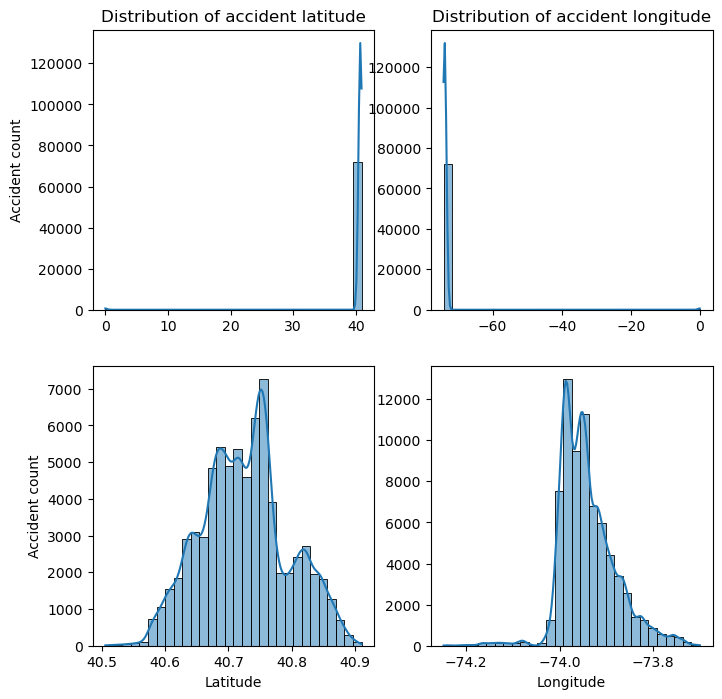

In [79]:
# First, I want to check the distribution of the coordinates

df_accidents = df_accidents.loc[df_accidents['bike_involved'] == 'bike'] # select only bike accidents

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1) # histogram for accident_latitude
sns.histplot(df_accidents['accident_latitude'], bins=30, kde=True)
plt.title('Distribution of accident latitude'); plt.xlabel(''); plt.ylabel('Accident count')

plt.subplot(2, 2, 2) # histogram for accident_longitude
sns.histplot(df_accidents['accident_longitude'], bins=30, kde=True)
plt.title('Distribution of accident longitude'); plt.xlabel(''); plt.ylabel('')

# I see that there are some outliers (must be incorrect entries) -> remove coordinates outside of NYC
# Approx. corner coordinates of NYC, drawing a square around the city in goodlemaps
corners = np.array([[40.935010, -74.283109],
    [40.937224, -73.682060],
    [40.468978, -73.693787],
    [40.480872, -74.276267]])

df_accidents_filt = df_accidents.loc[df_accidents['accident_latitude'].between(corners[:,0].min(), corners[:,0].max())]
df_accidents_filt  = df_accidents_filt.loc[df_accidents_filt['accident_longitude'].between(corners[:,1].min(), corners[:,1].max())]

plt.subplot(2, 2, 3) # histogram for accident_latitude (filtered)
sns.histplot(df_accidents_filt['accident_latitude'], bins=30, kde=True)
plt.xlabel('Latitude'); plt.ylabel('Accident count')

plt.subplot(2, 2, 4) # histogram for accident_longitude (filtered)
sns.histplot(df_accidents_filt['accident_longitude'], bins=30, kde=True)
plt.xlabel('Longitude'); plt.ylabel('')

plt.gca().yaxis.set_major_formatter(ScalarFormatter()) # depicting y-values as scientific for clarity
plt.gca().yaxis.get_major_formatter().set_scientific(True)

fig.savefig(os.path.join(results_dir,'accidents_distribution_coordinates.jpg'), format='jpg') # save figure

#plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False)) - set y-value format to default

We can see already that the accident hotspots are around latutude 40.75 and longitude -73.92, which corresponds with the calculated "hotspots_with_coordinates" df.

In [88]:
# Create a map with the accident density overlaid

m_accidents = folium.Map(location=[df_accidents_filt['accident_latitude'].median(), df_accidents_filt['accident_longitude'].median()], zoom_start=10)  
accidents_coords = list(zip(df_accidents_filt['accident_latitude'], df_accidents_filt['accident_longitude']))
HeatMap(accidents_coords, radius=20, blur=25, max_zoom=1).add_to(m_accidents)
#HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, gradient={0: 'yellow', 0.5: 'orange', 1: 'red'}).add_to(m_accidents)

#from folium import IFrame # notebook works too slow
# title = IFrame('<h3>Accidents Heatmap</h3>', width=200, height=50)
# popup = folium.Popup(title)
# folium.Marker(location=[df_accidents['accident_latitude'].mean(), df_accidents['accident_longitude'].mean()], popup=popup).add_to(m_accidents)

try:
    m_accidents.save(os.path.join(results_dir, 'map_bike_accidents.html')) # save
    print("Map saved successfully!")
except Exception as e:
    print(f"An error occurred: {e}")
    
#m_accidents # show -> makes notebook too big to push to Github repository with Git, so I just save it

del m_accidents # to clear up memory

Map saved successfully!


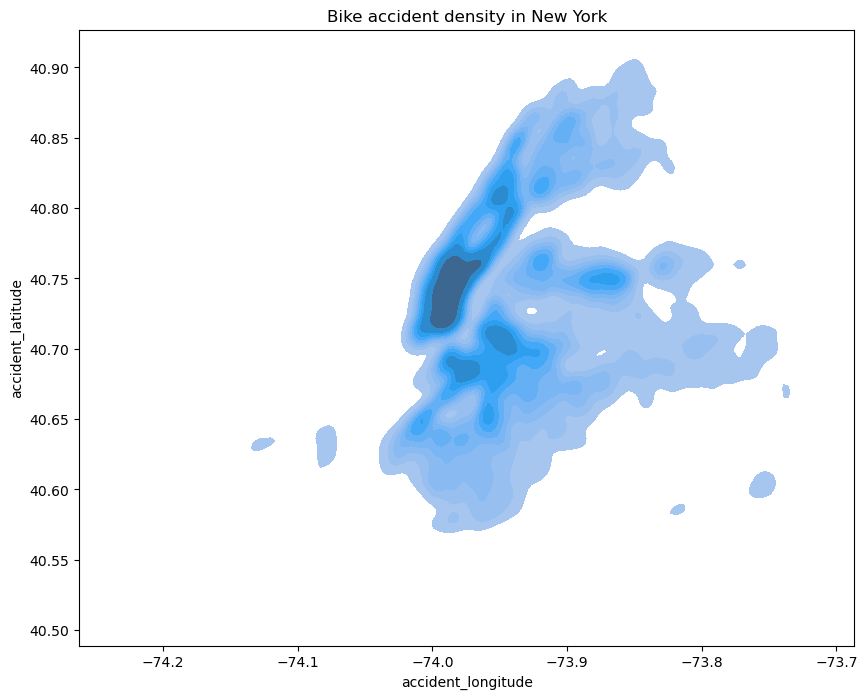

In [95]:
#df_accidents = df_accidents.sort_values(by=['accident_longitude','accident_latitude']) # esle it doesn´t work
df_sample = df_accidents_filt.sample(frac=1)  # take a % of the data for testing
df_sample = df_sample.sort_values(by=['accident_longitude','accident_latitude']) # else it doesn´t work

fig = plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_sample, x='accident_longitude', y='accident_latitude', fill=True, bw_adjust=0.5) #, cmap='Reds', bw_adjust=2
plt.title('Bike accident density in New York')

fig.savefig(os.path.join(results_dir,'accidents_bikes_density.jpg'), format='jpg') # save figure

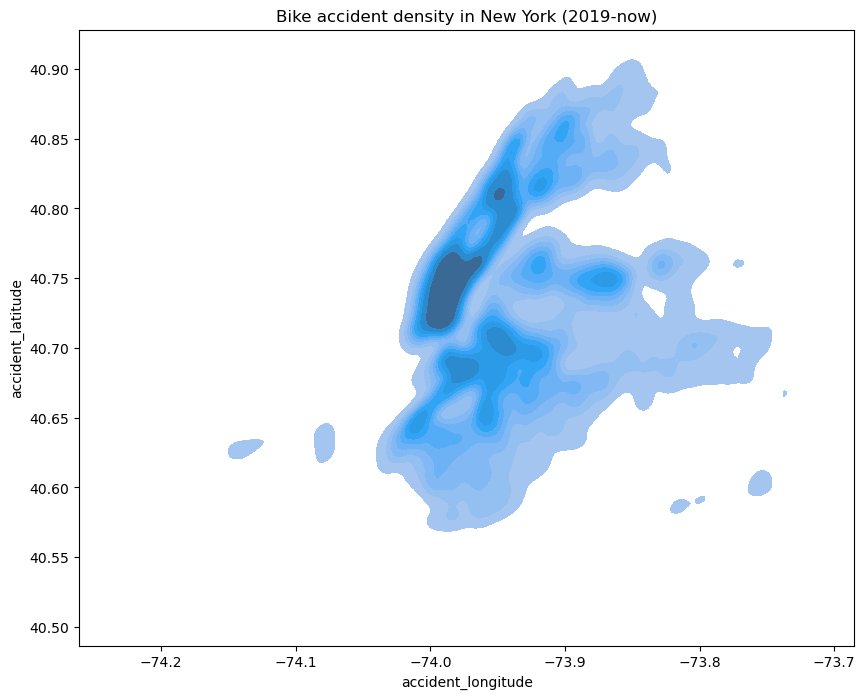

In [98]:
#df_accidents = df_accidents.sort_values(by=['accident_longitude','accident_latitude']) # esle it doesn´t work
df_select = df_accidents_filt.loc[df_accidents_filt['year'] > 2018]

df_sample = df_select.sample(frac=1)  # take 1% of the data for testing
df_sample = df_sample.sort_values(by=['accident_longitude','accident_latitude']) # else it doesn´t work

fig = plt.figure(figsize=(10, 8))
sns.kdeplot(data=df_sample, x='accident_longitude', y='accident_latitude', fill=True, bw_adjust=0.5) #, cmap='Reds', bw_adjust=2
plt.title('Bike accident density in New York (2019-now)')

fig.savefig(os.path.join(results_dir,'accidents_bikes_density2019-now.jpg'), format='jpg') # save figure

Now I will draw a square over NYC in googlemaps and bin the coordinates in 10 by 10, to get the number of accidents per square bin. Later I will do the same using the bike rental station coordinates, to plot a correlation graph.

In [87]:
# Extract min and max values for latitude and longitude
min_lat = corners[:,0].min()
max_lat = corners[:,0].max()
min_lon = corners[:,1].min()
max_lon = corners[:,1].max()

num_bins = 10 # create a grid of 10x10 bins
lat_bins = np.linspace(min_lat, max_lat, num_bins + 1)  # Latitude bins
lon_bins = np.linspace(min_lon, max_lon, num_bins + 1)  # Longitude bins

# Bin the latitude and longitude
df_accidents_filt['lat_bin'] = pd.cut(df_accidents_filt['accident_latitude'], bins=lat_bins)
df_accidents_filt['lon_bin'] = pd.cut(df_accidents_filt['accident_longitude'], bins=lon_bins)

# Count the number of accidents in each bin
counts = df_accidents_filt.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')

# Display the counts
print(counts)

count_matrix = counts.pivot_table(index='lat_bin', columns='lon_bin', values='count', fill_value=0) # create a 10x10 matrix (DataFrame) storing the counts

with open(os.path.join(results_dir,'bike_accidents_matrix.pkl'), 'wb') as f:
    pickle.dump(count_matrix, f)

count_matrix.head() # show

## Another way to do it creating an array
# incident_bins = np.nan(10, 10)
# for x in range(0, 10):
#     for y in range(0, 10):
#         incident_bins[x, y] = coordinates[(coordinates_long >= x) and (coordinates__long < x + 1) and 
#            (coordinates_lat >= y) and (coordinates_y < lat + 1)].count()

             lat_bin             lon_bin  count
0   (40.469, 40.516]  (-74.283, -74.223]     15
1   (40.469, 40.516]  (-74.223, -74.163]      1
2   (40.469, 40.516]  (-74.163, -74.103]      0
3   (40.469, 40.516]  (-74.103, -74.043]      0
4   (40.469, 40.516]  (-74.043, -73.983]      0
..               ...                 ...    ...
95   (40.89, 40.937]  (-73.983, -73.922]      0
96   (40.89, 40.937]  (-73.922, -73.862]     65
97   (40.89, 40.937]  (-73.862, -73.802]    140
98   (40.89, 40.937]  (-73.802, -73.742]      0
99   (40.89, 40.937]  (-73.742, -73.682]      0

[100 rows x 3 columns]


lon_bin,"(-74.283, -74.223]","(-74.223, -74.163]","(-74.163, -74.103]","(-74.103, -74.043]","(-74.043, -73.983]","(-73.983, -73.922]","(-73.922, -73.862]","(-73.862, -73.802]","(-73.802, -73.742]","(-73.742, -73.682]"
lat_bin,,,,,,,,,,
"(40.469, 40.516]",15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(40.516, 40.563]",6.0,84.0,56.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0
"(40.563, 40.609]",0.0,40.0,96.0,112.0,721.0,1542.0,48.0,155.0,232.0,1.0
"(40.609, 40.656]",0.0,18.0,274.0,259.0,3373.0,4010.0,837.0,20.0,16.0,14.0
"(40.656, 40.703]",0.0,0.0,0.0,0.0,2267.0,8130.0,3484.0,1377.0,701.0,112.0


## Comparisons and plots
Accident data:
- over time: mortality (% collisions resulting in death)
- cyclists killed and injured /year, split by gender and age (define age groups)

Bike ride data:
- trip duration member vs casual
- what time of the day are there most trips

Combined:
- heatmap of accidents and bikes rented

# Bike ride data

In [41]:
#df_rides = dd.read_parquet(cleaned_dir + '/combined_dask_df_cleaned.parquet', engine='pyarrow') # 10 GB, instead of 70 GB (raw data)
ddf = dd.read_parquet(os.path.join(cleaned_dir, 'combined_dask_df0810_cleaned.parquet'), columns=['birth_year', 'gender','user_type','trip_duration','year','month']) # read only specific columns, to reduce needed memory

print(ddf.dtypes)
print(ddf.shape[0].compute())
ddf.head()

birth_year          int32
gender           category
user_type        category
trip_duration       int32
year             category
month            category
dtype: object
124962115


,birth_year,gender,user_type,trip_duration,year,month
0,1972,NaN,Subscriber,456,2013,6
1,0,NaN,Customer,1024,2013,6
2,1970,NaN,Subscriber,2478,2013,6
3,1983,NaN,Subscriber,1373,2013,6
4,1987,NaN,Subscriber,1314,2013,6


In [210]:
# #ddf.group_by(['user_type','year']).sum()
# ddf['trip_duration_m'] = ddf['trip_duration'] / 60 # calculate trip duration in minutes
# ddf['trip_duration_h'] = ddf['trip_duration'] / 360 # calculate trip duration in hours
# ddf['year_month'] = pd.to_datetime(ddf[['year', 'month']].assign(day=1)) 

# grouped_ddf = ddf.groupby(['year', 'month', 'gender'])['trip_duration_h'].sum().reset_index()

# print(grouped_ddf.head())

# def plot_grouped_timeline(df, variable, group_by, xy_labels, plot_title, save_name):
#     sns.lineplot(
#         data=df,      
#         x='year_month',             
#         y=,            
#         hue='gender',         
#         marker='o',           
#         palette='coolwarm'    
#     )
    
#     plt.title(f'Value over Time by {group_by}')
#     plt.xlabel('Date')
#     plt.ylabel('Value')

#     plt.show()

# variable = 'trip_duration_h'
# group_by = 'member'
# xy_labels = [['Date (year, month)'],['Total rental duration (h/month)']]
# plot_title = 'Total bike rental duration per month'
# save_name = os.path.join(plot_dir, 'total_rental_duration_member.jpg')

# plot_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)
# plot_grouped_timeline(grouped_ddf, variable, group_by, xy_labels, save_name)

### Are there specific groups in the human population that rent more bikes (grouped by gender and age)?

In [6]:
# # calculate age of cyclists
# df_accidents.dropna(inplace=True) # drop all rows where any entry is NaN

# df_accidents['age'] = 2024 - df_accidents['birth_year']
# # Group age in 10 year periods; 0-10, 10-20 etc (remember that I set NaNs in birth_year to 0, as 2024-year olds do not exist)
# df_accidents['age_group'] = pd.cut(df_accidents['age'], bins=range(5, 95, 10), right=False, labels=[f'{i}-{i+9}' for i in range(0, 100, 10)])

# # filter/select data from the past 5 years for more actual/relevant visualizations (excluding 2024 since it´s only half over,so will show a misrepresentation)
# #df_filtered = df_accidents.loc[(df_accidents['year'] > 2018) & (df_accidents['year'] < 2024)] 
# df_filtered = df_filtered[df_filtered['year'].between(2019, 2023)]
# df_filtered = df_filtered[df_filtered['bike_involved'] == True]

# sns.catplot(data=df_filtered, x='year', hue='gender', col='age_group', kind='count', palette='Set2', height=5, aspect=1.5) # plot
# plt.subplots_adjust(top=0.85)
# plt.suptitle('Number of bike accidents per year (2019-2023) by gender and age group')
#plt.show()
#fig.savefig(os.path.join(fig_dir,'Monthly_collisions_total.jpg'), format='jpg') # save figure

In [24]:
# Since dataset is too big for my laptop, for this notebook to run smoothly, I take a random 10% sample here, so at least I can write & test code for plotting
df_sample = df_rides.sample(frac=0.1)
df_sample.to_parquet(os.path.join(cleaned_dir,'df_rides_sampled.parquet'), engine='pyarrow', partition_on=['year', 'month'], write_index=Fals)

In [ ]:
variables = ['number_of_cyclist_injured','number_of_cyclist_killed','number_of_motorist_injured']
period = 'month'
xy_labels = [['Date (year, month)','Date (year, month)','Date (year, month)'],['Number of cyclists injured','Number of cyclists killed','Number of motorists injured']]
plot_title = 'Number of people injured/killed during motor vehicle collisions'
label_colours_dict = {'number_of_cyclist_injured':'darkorange','number_of_cyclist_killed':'red','number_of_motorist_injured':'brown'}
save_name = 'monthly_accidents'

plot_accidents_timeline(df_accidents, variables, period, xy_labels, plot_title, label_colours_dict, save_name)

# Heatmaps of bike rentals and collisions (latitude & longitude)

In [90]:
df_rides_loc['start_station_latitude']

0          40.742355
1          40.742355
2          40.695129
3          40.735241
4          40.705692
             ...    
4709255    40.742256
4709256    40.731010
4709257    40.737431
4709258    40.749943
4709259    40.747906
Name: start_station_latitude, Length: 124947806, dtype: float32

In [91]:
# drop missing values and select only coordinates from df_rides

df_rides_loc = df_rides[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']].compute().dropna()

print(df_rides_loc.head())
print(df_rides_loc.shape)

df_accidents = df_accidents.dropna(subset=['accident_latitude', 'accident_longitude'], axis=0) 

# Concatenate latitude and longitude start+stop bike station
bike_station_coord = pd.DataFrame(columns=['station_latitude','station_longitude'])
bike_station_coord['station_latitude'] = pd.concat([df_rides_loc['start_station_latitude'],df_rides_loc['end_station_latitude']])
bike_station_coord['station_longitude'] = pd.concat([df_rides_loc['start_station_longitude'],df_rides_loc['end_station_longitude']])

bike_station_coord.head() # check
print(bike_station_coord.shape)

,station_latitude,station_longitude
0,40.742355,-73.989151
1,40.742355,-73.989151
2,40.695129,-73.995949
3,40.735241,-73.987587
4,40.705692,-74.016777


In [ ]:
# create a map of NYC with the center coordinates [median lat, median long] of the dataset
# downsampled bike rides, since the dataset is too big

m_rides = folium.Map(location=[bike_station_coord['station_latitude'].median(), 
                               bike_station_coord['station_longitude'].median()], zoom_start=10) 
rides_coords = list(zip(bike_station_coord['station_latitude'], bike_station_coord['station_longitude']))
HeatMap(rides_coords, radius=15, blur=20, max_zoom=1).add_to(m_rides) # add the heatmap to map

m_rides # show

m_rides.save(os.path.join(fig_dir, 'map_bike-rides.html')) # save

#del m_rides # to clear up memory

### Create a map with the bike ride density overlaid

In [ ]:
# m_accidents = folium.Map(location=[df_accidents['accident_latitude'].median(), df_accidents['accident_longitude'].median()], zoom_start=10)  
# accidents_coords = list(zip(df_accidents['accident_latitude'], df_accidents['accident_longitude']))
# HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, gradient={0: 'yellow', 0.5: 'orange', 1: 'red'}).add_to(m_accidents)
# rides_coords = list(zip(bike_station_coord['station_latitude'], bike_station_coord['station_longitude'])) 

HeatMap(accidents_coords, radius=15, blur=20, max_zoom=1, gradient={0: 'yellow', 0.5: 'orange', 1: 'red'}).add_to(m_accidents) # add the heatmap to accident map

m_accidents # show

m_accidents.save(os.path.join(fig_dir, 'map_accidents_bike-stations_overlay.html'))

#del m_rides m_accidents

In [ ]:
fig = plt.figure(figsize=(15, 5))

# Plot for accidents
plt.subplot(1, 3, 1)
sns.kdeplot(data=df_accidents_pd, x='accident_longitude', y='accident_latitude', fill=True)
plt.title('Accidents Density')

# Plot for bike rides
plt.subplot(1, 3, 2)
sns.kdeplot(data=rides_coords, x='station_longitude', y='station_latitude', fill=True)
plt.title('bike station use density')

# Overlay
plt.subplot(1, 3, 3)
sns.kdeplot(data=df_accidents_pd, x='accident_longitude', y='accident_latitude', fill=True, color='red', alpha=0.5)
sns.kdeplot(data=df_rides_pd, x='end_longitude', y='end_latitude', fill=True, color='blue', alpha=0.5)
plt.title('Overlay of accidents and bike station use density')

plt.tight_layout()
plt.show()

#fig.savefig(os.path.join(fig_dir, 'density_plot_accidents_bike-rides'))